In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)
    # 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass
import torch
# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor,ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
# 4. Wandb Tracker Experiements
import wandb

In [3]:
# Generate microscopy 
df = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t')
df = df[(df['higher_modality']=='MICROSCOPY')&(df['modality'].isna()==0)].reset_index(drop = True)
df['target'] = df['modality']
df.to_csv('../data/microscopy_v1.csv',sep = '\t',index = False)

In [5]:
BASE_PATH = Path('/mnt')
print(f"My base path is {BASE_PATH}")
DATA_PATH = '../data/microscopy_v1.csv'
print(f"The given dataset is located here: {DATA_PATH}")
OUTPUT_DIR = Path('/mnt/artifacts/experiments/')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH       # the image path in the CSV file are relative to this directory
NAME_OUTPUT  = 'microscopy_v1'

My base path is /mnt
The given dataset is located here: ../data/microscopy_v1.csv
Let's use this folder: /mnt/artifacts/experiments to save our artifacts.


In [6]:
SEED = 42 
seed_everything(42)
PROJECT = 'Biomedical-Image-Classification-Microscopy'
NUM_WORKERS = 72 # workers on the cluster, normally 2 or 4 on a laptop
METRIC_MONITOR = "val_avg_loss"
MODE           = 'min'
EXTENSION      = '.pt'
OUTPUT_PROJECT = OUTPUT_DIR/PROJECT
print(f"Let's use this folder {OUTPUT_PROJECT} to save our sweep iterations")
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

Let's use this folder /mnt/artifacts/experiments/Biomedical-Image-Classification-Microscopy to save our sweep iterations


In [7]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder,dict_label = label_encoder_target(df,target_col='modality')
dict_label

{'DMEL': 0, 'DMFL': 1, 'DMLI': 2, 'DMTR': 3}

In [8]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
]
transform  = transforms.Compose(transform_list)
train_dataset   = ImageDataset   (DATA_PATH,
                                  le_encoder,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform,
                                  label_name='modality',
                                  target_class_col='split_set',
                                  path_col='img_path')

mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=NUM_WORKERS)
print(f"Mean:  {mean}")
print(f"Std :  {std}")


Mean:  tensor([0.4927, 0.4800, 0.4825])
Std :  tensor([0.3625, 0.3544, 0.3654])


In [9]:
# Image Transformations
# 1.1 Train Transformations
train_transform = [
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean.numpy(), std.numpy())
                ]
train_transform  = transforms.Compose(train_transform )

# 1.2 Valid Transformations
val_transform = [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ]
val_transform = transforms.Compose(val_transform)

# 1.3 Test Transformations
test_transform = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean.numpy(),std.numpy())
                  ]
test_transform = transforms.Compose(test_transform)

In [10]:
print(f"PROJECT NAME: {PROJECT}")
print(f"Metric Monitor: {METRIC_MONITOR}")

PROJECT NAME: Biomedical-Image-Classification-Microscopy
Metric Monitor: val_avg_loss


### 4.1 ResnetClassifier

In [11]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [0.00001]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["resnet18"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [16]
            
        }
      
    }
}

In [12]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: 9ubw32vq
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Microscopy/sweeps/9ubw32vq


In [13]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)
print(OUTPUT_SWEEP)

/mnt/artifacts/experiments/Biomedical-Image-Classification-Microscopy/9ubw32vq


In [14]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = NUM_WORKERS,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode=MODE
    )
    
    checkpoint_callback = ModelCheckpoint(dirpath    = output_run_path,
                                          filename   = NAME_OUTPUT,
                                          monitor    = METRIC_MONITOR,
                                          mode       = MODE,
                                          save_top_k = 1)

    checkpoint_callback.FILE_EXTENSION = EXTENSION
    
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.modality.unique())
    print(f"Num_Classes {num_classes}")
    model = ResNetClass(      name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = MODE,
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean.numpy(),
                              std_dataset     = std.numpy())
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor,checkpoint_callback],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Get testS metric
    del model
    model = ResNetClass.load_from_checkpoint(output_run_path/(NAME_OUTPUT + EXTENSION))
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model,trainer
    torch.cuda.empty_cache() 
    wandb.finish()

wandb: Agent Starting Run: 3tfrxxoc with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet18
wandb: Currently logged in as: williamberrios (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: genial-sweep-1
Num_Classes 4


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Epoch    15: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 92.25806427001953
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.78        53
         1.0       0.97      0.97      0.97       203
         2.0       0.98      0.94      0.96       130
         3.0       0.80      0.90      0.85        79

    accuracy                           0.92       465
   macro avg       0.89      0.89      0.89       465
weighted avg       0.93      0.92      0.92       465


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8893574845470286,
 'Macro F1-Score': 0.8876170700480132,
 'Macro Precision': 0.8879802016084175,
 'Macro Recall': 0.8893574845470286,
 'test_acc': tensor(92.2581, device='cuda:0'),
 'test_loss': tensor(0.2946, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,3743
_runtime,244
_timestamp,1616119034
val_acc,90.96774
val_avg_loss,0.3588
epoch,15
train_acc,97.31903
train_avg_loss,0.11121
test_acc,92.25806
test_loss,0.2946


lr-Adam,███████████████▁
_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▇▇▇▇███▇▇█▆▇▇▇▇
val_avg_loss,█▄▂▃▂▁▂▂▁▁▁▂▁▃▂▂
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train_acc,▁▆▇▇▇▇▇▇▇▇█▇████
train_avg_loss,█▄▃▃▃▃▂▂▂▂▁▂▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


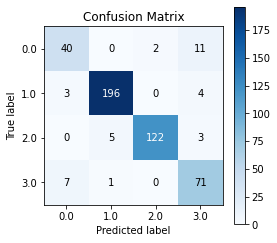

In [15]:
wandb.agent(sweep_id, function=sweep_iteration);

In [18]:
cp /mnt/artifacts/experiments/Biomedical-Image-Classification-Microscopy/9ubw32vq/genial-sweep-1/microscopy_v1.pt /mnt/artifacts/models/Microscopy/

In [19]:
model_path = '/mnt/artifacts/models/Microscopy/microscopy_v1.pt'
dm = ImageDataModule( batch_size       = 32,
                      label_encoder    = le_encoder,
                      data_path        = str(DATA_PATH), 
                      base_img_dir     = str(BASE_IMG_DIR),
                      seed             = SEED,   
                      image_transforms = [train_transform,val_transform,test_transform],
                      num_workers      = NUM_WORKERS,
                      target_class_col ='split_set',
                      modality_col     ='modality',
                      path_col         ='img_path')
dm.prepare_data()
dm.setup()
dm.set_seed()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 86.59793853759766
              precision    recall  f1-score   support

         0.0       0.51      0.38      0.43        88
         1.0       0.93      0.93      0.93       284
         2.0       0.93      0.96      0.94       405
         3.0       0.68      0.73      0.70        96

    accuracy                           0.87       873
   macro avg       0.76      0.75      0.75       873
weighted avg       0.86      0.87      0.86       873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.7488224873934968,
 'Macro F1-Score': 0.7516155677945873,
 'Macro Precision': 0.7599729261400602,
 'Macro Recall': 0.7488224873934968,
 'test_acc': tensor(86.5979, device='cuda:0'),
 'test_loss': tensor(0.4384, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_acc': 86.59793853759766,
  'test_loss': 0.43835049867630005,
  'Macro F1-Score': 0.7516155677945873,
  'Balanced Accuracy': 0.7488224873934968,
  'Macro Recall': 0.7488224873934968,
  'Macro Precision': 0.7599729261400602}]

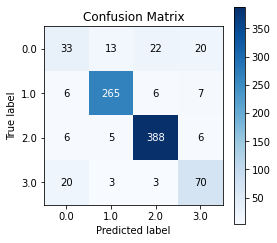

In [20]:
model = ResNetClass.load_from_checkpoint(model_path)
trainer = Trainer(gpus=1, logger=None)
trainer.test(model, test_dataloaders=dm.test_dataloader())